In [1]:
# Import Packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
 

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import optuna

from sklearn.pipeline import Pipeline

import datetime
import os

from sklearn.model_selection import cross_val_score,train_test_split
from catboost import CatBoostClassifier

from sklearn.feature_selection import SelectKBest, f_classif

In [2]:

dir = './Dataset/'
file_path = os.path.join(dir, 'credit_default.csv')

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
else:
    print("File not found: data.csv")


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   UserID             6000 non-null   object
 1   Sex                6000 non-null   object
 2   PreviousDefault    6000 non-null   int64 
 3   FirstName          6000 non-null   object
 4   LastName           6000 non-null   object
 5   NumberPets         6000 non-null   int64 
 6   PreviousAccounts   6000 non-null   int64 
 7   ResidenceDuration  6000 non-null   int64 
 8   Street             6000 non-null   object
 9   LicensePlate       6000 non-null   object
 10  BadCredit          6000 non-null   int64 
 11  Amount             6000 non-null   int64 
 12  Married            6000 non-null   int64 
 13  Duration           6000 non-null   int64 
 14  City               6000 non-null   object
 15  Purpose            6000 non-null   object
 16  DateOfBirth        6000 non-null   object


c:\Users\carni\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\carni\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\carni\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\carni\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

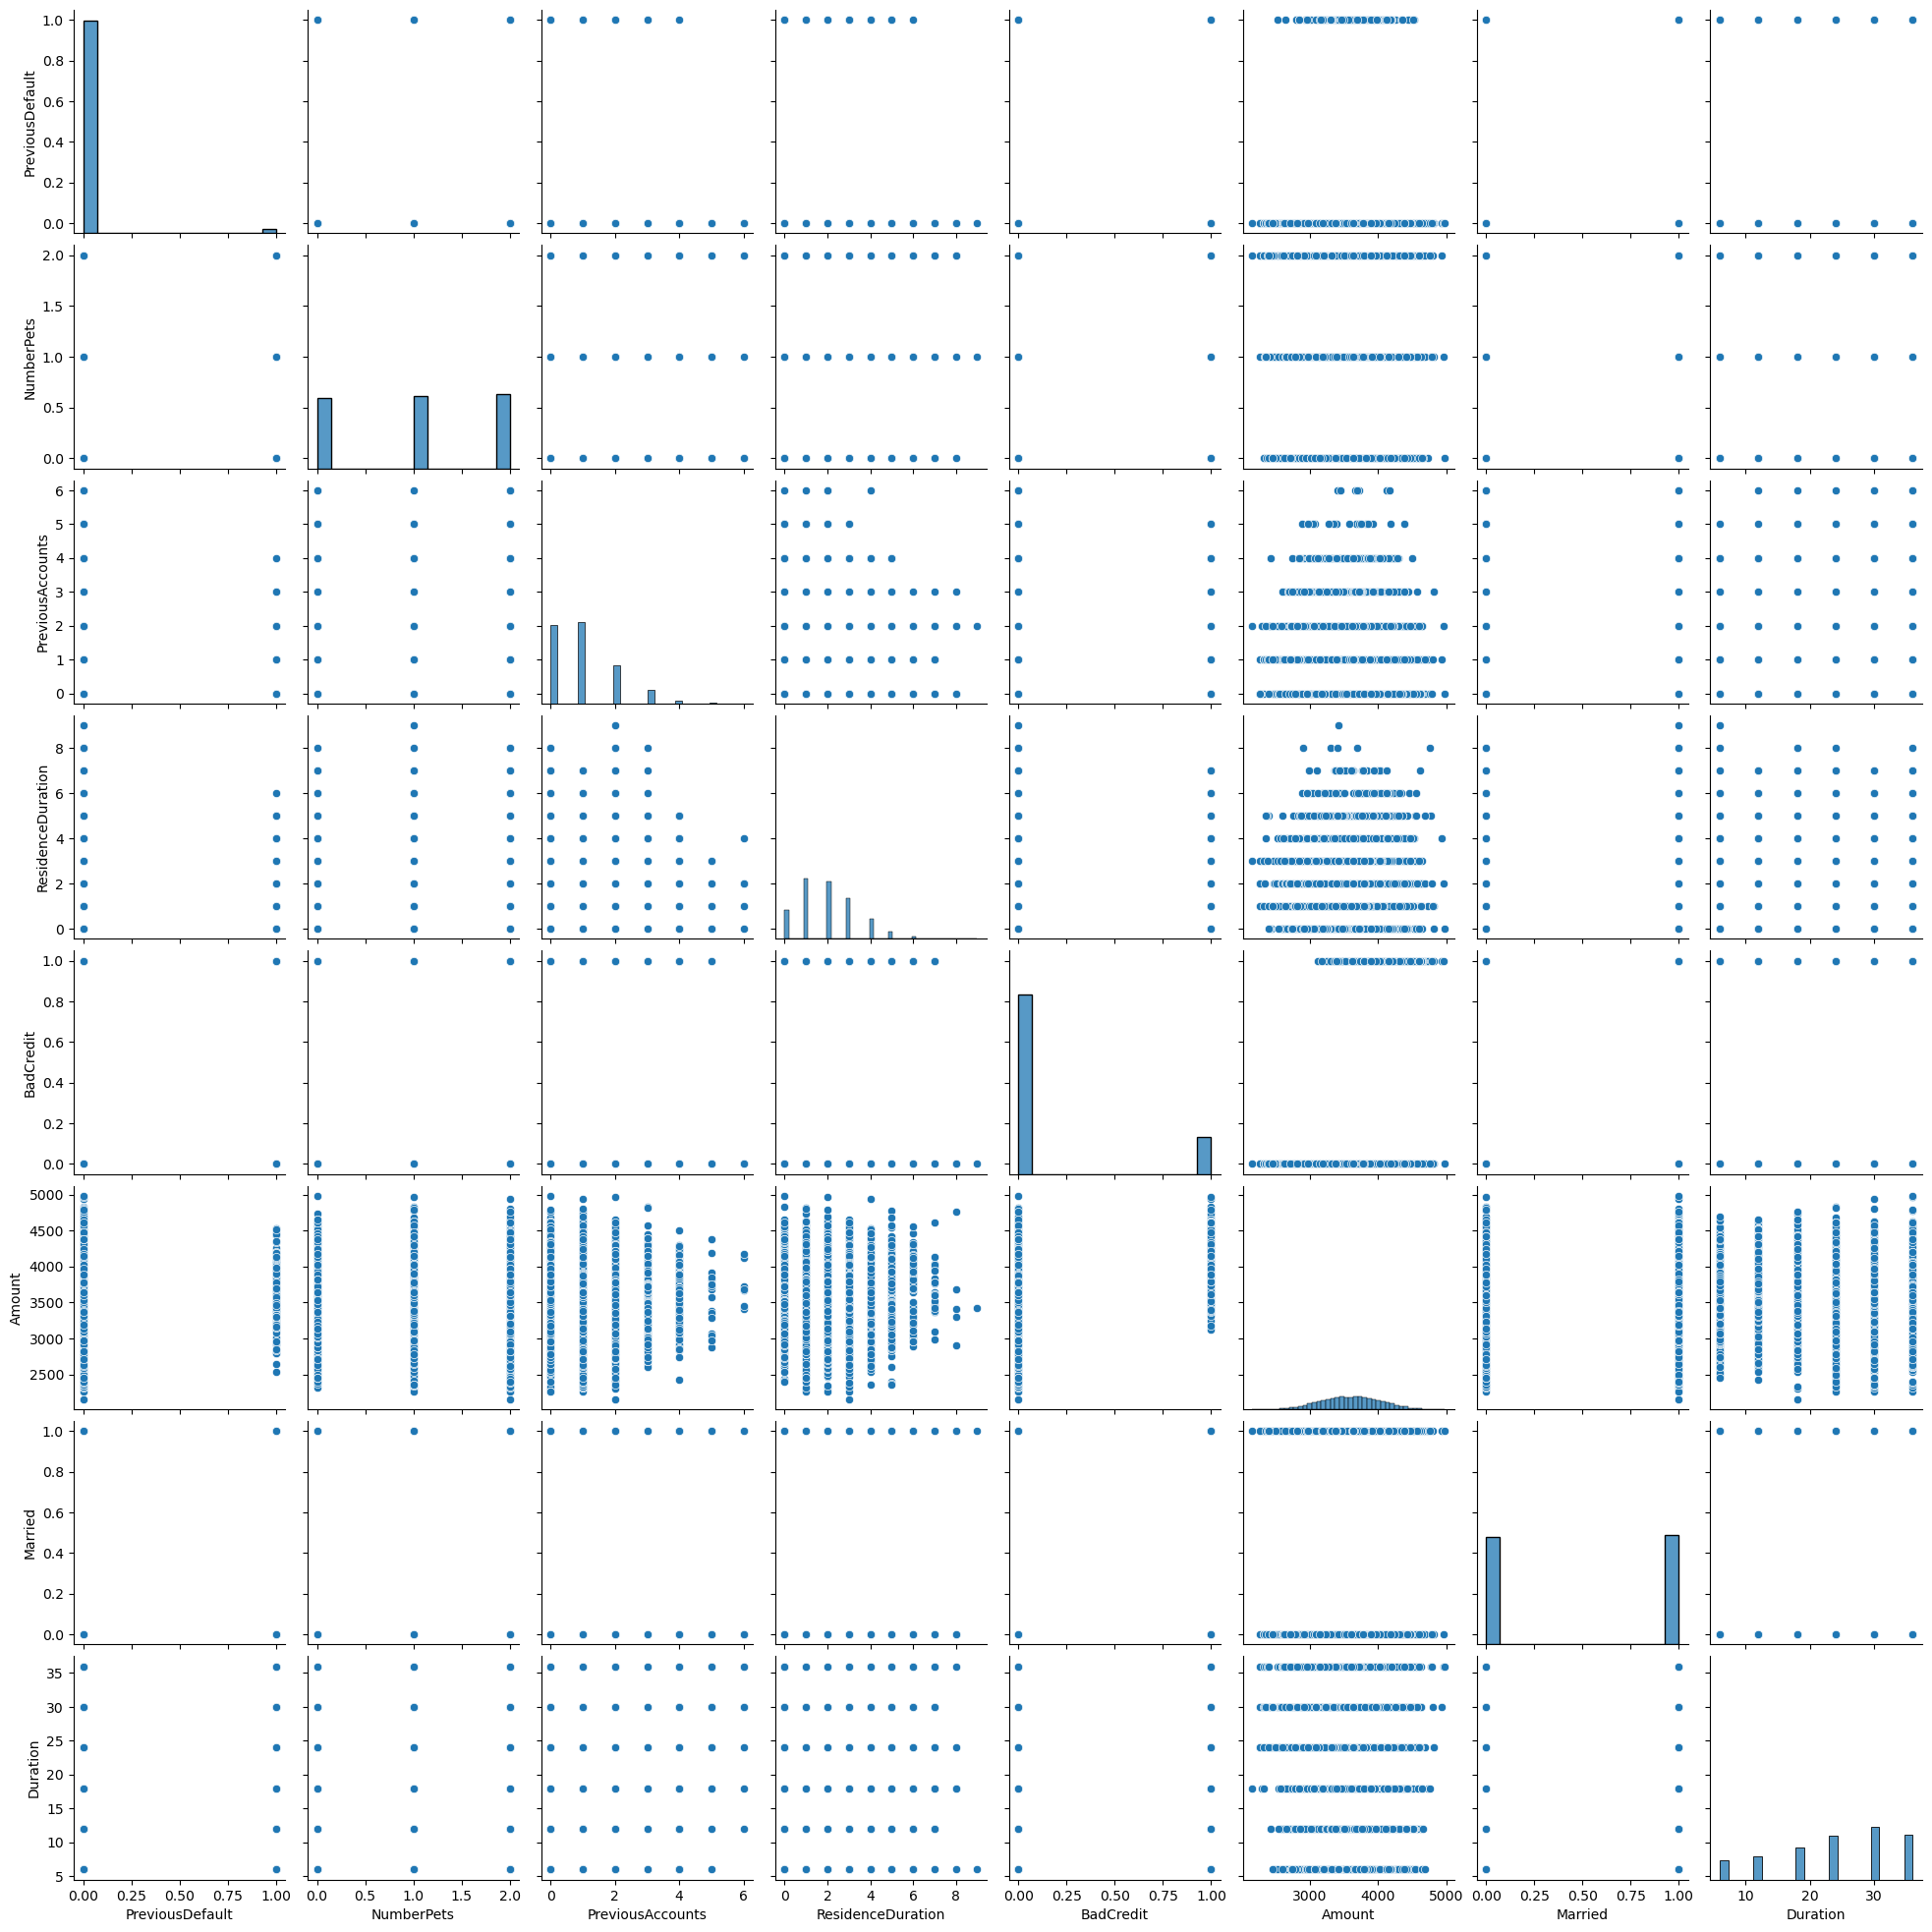

In [5]:
sns.pairplot(df)
plt.show()

In [6]:

X = df.drop('BadCredit', axis=1) #.select_dtypes(['number'])
y = df['BadCredit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Engineering

Two Features Added:
1. Age baesd on DOB
2. Interaction varaiable based on duration and amount

In [7]:
def feature_eng(df):
  temp_df =df.copy()

  # Add age based on DOB
  today = datetime.datetime.now()
  temp_df['DateOfBirth'] = pd.to_datetime(temp_df['DateOfBirth'])
  # today = datetime.now()
  temp_df['age'] = today.year - temp_df['DateOfBirth'].dt.year
  # interaction varaible
  temp_df['duration_plus_amount'] = temp_df['Duration'] + temp_df['Amount']
  temp_df['duration_minus_amount'] = temp_df['Duration'] - temp_df['Amount']
  temp_df['duration_multi_amount'] = temp_df['Duration'] * temp_df['Amount']
  temp_df['duration_div_amount'] = temp_df['Duration'] / temp_df['Amount']

  return temp_df

In [8]:
X_train = feature_eng(X_train)
X_test = feature_eng(X_test)

## Create a baseline model just to checkout how things are going

In [9]:
# Columns to drop and to apply one-hot encoding
columns_to_drop = ['UserID','FirstName','LastName','Street','LicensePlate','DateOfBirth','Duration','Amount']
columns_to_encode = ['Sex','City','Purpose']
num_columns =['PreviousDefault', 'NumberPets', 'PreviousAccounts',
       'ResidenceDuration', 'Amount', 'Married', 'Duration', 'age',
       'duration_plus_amount', 'duration_minus_amount',
       'duration_multi_amount', 'duration_div_amount']
# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('drop', 'drop', columns_to_drop),
        ('onehot', OneHotEncoder(), columns_to_encode),
        ('scaler', StandardScaler(),num_columns),
    ],
    remainder='passthrough'  # keeps the columns not specified in transformers
)
# Define the CatBoost model
catboost_model = CatBoostClassifier(verbose=False)
# Create pipeline
pipeline_2 = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', catboost_model)])


# Perform cross-validation and then calculate scores
scores = cross_val_score(pipeline_2, X_train, y_train, cv=5,scoring="f1")

# Output the mean accuracy
print(f"Mean CV F1: {scores.mean():.2f}")

Mean CV F1: 0.63


## Hyperparameter tuning

In [23]:
def objective(trial,X,y):
    # Hyperparameters to tune
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),  
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'max_bin': trial.suggest_int('max_bin', 100, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 5), 
        # Fixed parameters
        'iterations': 1000,
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'auto_class_weights': 'Balanced',
        # Add other parameters as needed
    }
    # Feature selection
    k = trial.suggest_int('k', 16, 42)

    columns_to_drop = ['UserID','FirstName','LastName','Street','LicensePlate','DateOfBirth','Duration','Amount']
    columns_to_encode = ['Sex','City','Purpose']
    num_columns =['PreviousDefault', 'NumberPets', 'PreviousAccounts',
          'ResidenceDuration', 'Amount', 'Married', 'Duration', 'age',
          'duration_plus_amount', 'duration_minus_amount',
          'duration_multi_amount', 'duration_div_amount']
    # Column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('drop', 'drop', columns_to_drop),
            ('onehot', OneHotEncoder(), columns_to_encode),
            ('scaler', StandardScaler(),num_columns),
        ],
        remainder='passthrough'  # keeps the columns not specified in transformers
    )

    # Pipeline definition
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_classif, k=k)),
        ('classifier', CatBoostClassifier(verbose=False, **param))
    ])


    scores = cross_val_score(pipeline, X, y, cv=5, scoring="f1")


    return np.mean(scores)


# Create a study object and specify the direction is 'maximize'.
study = optuna.create_study(direction='maximize')

# Start the optimization
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=10,  gc_after_trial=True)


print(study.best_params)

[I 2024-05-06 17:23:32,524] A new study created in memory with name: no-name-0f61c598-a516-4f42-b9a7-52993f601496
[I 2024-05-06 17:24:34,897] Trial 0 finished with value: 0.6231367622432658 and parameters: {'learning_rate': 0.1904754478317992, 'depth': 9, 'min_data_in_leaf': 13, 'max_bin': 253, 'l2_leaf_reg': 2.6930556478978662, 'k': 18}. Best is trial 0 with value: 0.6231367622432658.
[I 2024-05-06 17:24:49,720] Trial 1 finished with value: 0.6145886429805867 and parameters: {'learning_rate': 0.2751274104819636, 'depth': 5, 'min_data_in_leaf': 37, 'max_bin': 246, 'l2_leaf_reg': 2.371010941465398, 'k': 23}. Best is trial 0 with value: 0.6231367622432658.
[I 2024-05-06 17:25:16,100] Trial 2 finished with value: 0.6124246492660737 and parameters: {'learning_rate': 0.28776199385871376, 'depth': 7, 'min_data_in_leaf': 30, 'max_bin': 297, 'l2_leaf_reg': 3.6004739428780326, 'k': 38}. Best is trial 0 with value: 0.6231367622432658.
[I 2024-05-06 17:25:30,540] Trial 3 finished with value: 0.66

{'learning_rate': 0.02533783702531472, 'depth': 5, 'min_data_in_leaf': 17, 'max_bin': 110, 'l2_leaf_reg': 0.7439314748097314, 'k': 38}


## Inference On Test Dataset

In [24]:
best_params = study.best_params
best_params.pop('k')
best_params.update({
    'loss_function': 'Logloss',
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    'verbose': False 
})

In [27]:
# Columns to drop and to apply one-hot encoding
columns_to_drop = ['UserID','FirstName','LastName','Street','LicensePlate','DateOfBirth','Duration','Amount']
columns_to_encode = ['Sex','City','Purpose']
num_columns =['PreviousDefault', 'NumberPets', 'PreviousAccounts',
      'ResidenceDuration', 'Amount', 'Married', 'Duration', 'age',
      'duration_plus_amount', 'duration_minus_amount',
      'duration_multi_amount', 'duration_div_amount']

param = {'learning_rate': 0.010287087681540574,
         'depth': 8,
         'min_data_in_leaf': 36,
         'max_bin': 227,
         'l2_leaf_reg': 3.50597897095724,
         'iterations': 1000,
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'auto_class_weights': 'Balanced',
         'verbose':False,}
# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('drop', 'drop', columns_to_drop),
        ('onehot', OneHotEncoder(), columns_to_encode),
        ('scaler', StandardScaler(),num_columns),
    ],
    remainder='passthrough'  # keeps the columns not specified in transformers
)
# Define the CatBoost model
catboost_model = CatBoostClassifier(**param)
# Create pipeline
pipeline_2 = Pipeline(steps=[('preprocessor', preprocessor),
                             ('feature_selection', SelectKBest(score_func=f_classif, k=40)),
                           ('classifier', catboost_model)])


# fit
pipeline_2.fit(X_train, y_train)
X_test = feature_eng(X_test)

predict = pipeline_2.predict(X_test)
f1_score(y_test, predict)

0.674698795180723